In [118]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)

from os import path
from PIL import Image
import os

from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, silhouette_samples, silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from pprint import pprint

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.porter import PorterStemmer as PS

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to /Users/coxem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

In [2]:
texts = pd.read_csv('data/dataset.csv')
texts.head(10)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
2,What do you call a turtle without its shell? dead.,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False
5,"Martha stewart tweets hideous food photo, twitter responds accordingly",False
6,What is a pokemon master's favorite kind of pasta? wartortellini!,True
7,Why do native americans hate it when it rains in april? because it brings mayflowers.,True
8,"Obama's climate change legacy is impressive, imperfect and vulnerable",False
9,"My family tree is a cactus, we're all pricks.",True


In [3]:
texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [4]:
texts.humor.unique()

array([False,  True])

In [5]:
texts.humor.value_counts()

True     100000
False    100000
Name: humor, dtype: int64

In [6]:
texts.text[0]

"Joe biden rules out 2020 bid: 'guys, i'm not running'"

In [7]:
texts_humor = texts[texts['humor'] == True]
texts_humor.head()

,text,humor
2,What do you call a turtle without its shell? dead.,True
6,What is a pokemon master's favorite kind of pasta? wartortellini!,True
7,Why do native americans hate it when it rains in april? because it brings mayflowers.,True
9,"My family tree is a cactus, we're all pricks.",True
13,How are music and candy similar? we throw away the rappers.,True


In [8]:
texts_serious = texts[texts['humor'] == False]
texts_serious.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not running'",False
1,Watch: darvish gave hitter whiplash with slow pitch,False
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind, new autopsy shows",False
5,"Martha stewart tweets hideous food photo, twitter responds accordingly",False


## Train, Test, Split

In [9]:
X = texts['text']

In [10]:
y = texts['humor']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y)

In [12]:
X_train

172770    I have a step ladder i never met my real ladder.                              
71124     What do you call a gay dinosaur? a very soar arse                             
135380    What do you call a paraplegic with an incurable std? roll-aids.               
30845     What are the unspoken rules of sign language? all of them                     
73643     5 genius wedding registry tips from giada de laurentiis                       
                                   ...                                                  
95649     Vatican issues first comments on trump's immigration ban                      
63575     If atlas supported the world on his shoulders who supported atlas ? his wife !
15529     What's one thing you hated as a kid but love as an adult? molestation.        
19674     Gop hopeful on budget: cut porno-watching gov't employees                     
89107     Lebron james once gained 7 pounds in a single nba playoff game                
Name: text, Length: 1

## Developing Corpus Cleaning Pipeline

> * For my Naive Bayes model, I wanted to try to use a stemmed corpus prior to fit_transforming the tfidf vectorizer, because without it, there were a lot of duplicated words in various forms (e.g. charged, charge, charges, etc.). In order to do this, I had to write a function to which would stem the corpus, and I just went ahead and cleaned the text up (removed punctuation, stopwords, and used porter stemmer) then put it back in the raw corpus format (list of strings).
> * This ended up resulting in a lower accuracy, but worked really well for making my wordcloud

In [13]:
# texts_list = [text.lower() for text in X]
# texts_list

In [14]:
# tokenizer = RegexpTokenizer("[\w']+")

In [15]:
# tokens = list(map(tokenizer.tokenize, texts_list))
# tokens

In [16]:
# punc = set(string.punctuation)
# tokens_no_punc = [[word for word in words if word not in punc]
#         for words in tokens]
# tokens_no_punc

In [17]:
# s_words = set(stopwords.words('english'))
# tokens_no_sw = [[word for word in words if word not in s_words]
#         for words in tokens_no_punc]
# tokens_no_sw

In [18]:
# porter = PS()
# texts_ps = [[porter.stem(word) for word in text] for text in tokens_no_sw]
# texts_ps

In [19]:
# texts_ps_joined = [' '.join(word) for word in texts_ps]
# texts_ps_joined

In [20]:
def clean_corpus(X):
    '''
    Takes in a series or list of strings.
    Returns one string of cleaned text.
    '''
    # lowercase the strings
    corpus = [text.lower() for text in X] 

    # declare regular expression tokenizer
    # split strings into words while keeping contractions together
    tokenizer = RegexpTokenizer("[\w']+")
    tokens = list(map(tokenizer.tokenize, corpus)) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    # join all words into one string
    cleaned_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return cleaned_corpus

In [56]:
def old_clean_corpus(X):
    '''
    Takes in a series or list of strings.
    Returns one string of cleaned text.
    '''
    # lowercase the strings
    corpus = [text.lower() for text in X] 

    # declare regular expression tokenizer
    # split strings into words while keeping contractions together
    tokens = list(map(word_tokenize, corpus)) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    # join all words into one string
    cleaned_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return cleaned_corpus

## Humor Word Cloud and Serious Word Cloud

In [21]:
#https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py

# Define path
path_ = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask / color image taken from
laugh_emoji = np.array(Image.open(path.join(path_, "images/rolling-on-the-floor-laughing.png")))
straight_face_emoji = np.array(Image.open(path.join(path_, "images/expressionless-face.png")))

# create coloring from image
humor_image_colors = ImageColorGenerator(laugh_emoji)
serious_image_colors = ImageColorGenerator(straight_face_emoji)

In [57]:
# def old_word_cloud(corpus, wordcloud_obj):
#     cleaned_corpus = ' '.join(old_clean_corpus(corpus))
#     word_cloud = wordcloud_obj
#     word_cloud.generate(cleaned_corpus)
#     return word_cloud

In [58]:
# wc_humor_old = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=laugh_emoji, max_font_size=50)

In [61]:
# old_word_cloud_humor = old_word_cloud(texts_humor.text, wc_humor_old)

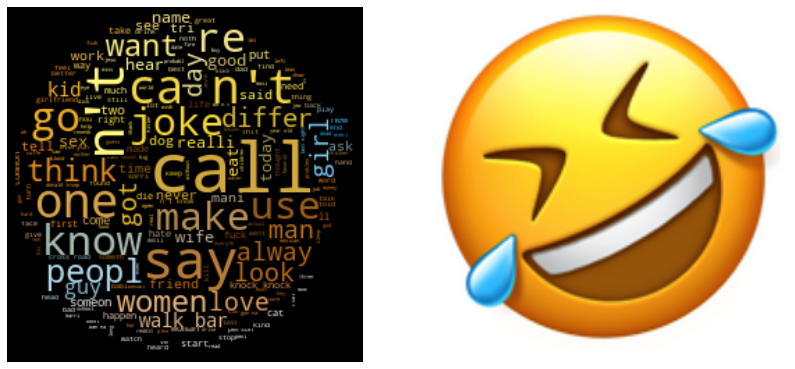

In [62]:
# fig, axes = plt.subplots(1, 2, figsize=(14,10))
# axes[0].imshow(old_word_cloud_humor.recolor(color_func=humor_image_colors), interpolation="bilinear")
# axes[1].imshow(laugh_emoji, cmap=plt.cm.gray, interpolation="bilinear")

# for ax in axes:
#     ax.set_axis_off()

In [22]:
def make_word_cloud(corpus, wordcloud_obj):
    cleaned_corpus = ' '.join(clean_corpus(corpus))
    word_cloud = wordcloud_obj
    word_cloud.generate(cleaned_corpus)
    return word_cloud

In [23]:
wc_humor = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=laugh_emoji, max_font_size=50)

In [24]:
word_cloud_humor = make_word_cloud(texts_humor.text, wc_humor)

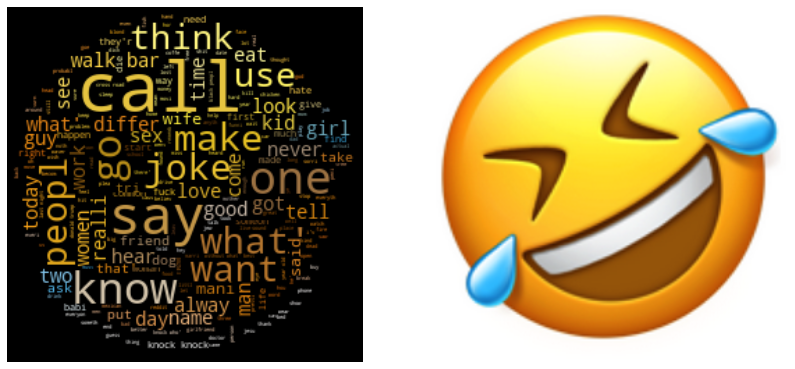

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))
axes[0].imshow(word_cloud_humor.recolor(color_func=humor_image_colors), interpolation="bilinear")
axes[1].imshow(laugh_emoji, cmap=plt.cm.gray, interpolation="bilinear")

for ax in axes:
    ax.set_axis_off()
    
#plt.savefig('wc_humor.png')

In [26]:
def get_top_words(word_cloud, num_words=10):
    word_list = list(word_cloud.words_)
    top_words = word_list[:num_words]
    return f'The top {num_words} words are: {", ".join(top_words)}'

In [27]:
get_top_words(word_cloud_humor)

"The top 10 words are: call, say, one, know, go, make, what', joke, peopl, want"

In [28]:
wc_serious = WordCloud(background_color="black", relative_scaling=0.5, max_words=None, mask=straight_face_emoji, max_font_size=50)

In [29]:
word_cloud_serious = make_word_cloud(texts_serious.text, wc_serious)

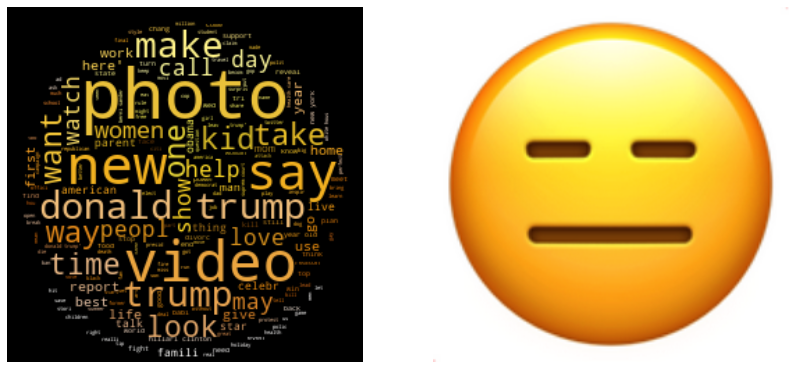

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))
axes[0].imshow(wc_serious.recolor(color_func=serious_image_colors), interpolation="bilinear")
axes[1].imshow(straight_face_emoji, cmap=plt.cm.gray, interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()

#plt.savefig('wc_serious.png')

In [33]:
get_top_words(word_cloud_serious)

'The top 10 words are: photo, video, new, say, donald trump, trump, make, one, kid, take'

## Featurizing the Text

In [34]:
# tfid = TfidfVectorizer(max_features=1000)
# text_train = tfid.fit_transform(X_train_clean)
# feature_names = tfid.get_feature_names()
# feature_names

In [35]:
# tfid = TfidfVectorizer(stop_words='english', max_features=1000)
# text_train = tfid.fit_transform(X_train)
# feature_names = tfid.get_feature_names()
# feature_names

In [36]:
# len(feature_names)

In [37]:
# text_train_df = pd.DataFrame(text_train.todense(), columns = tfid.vocabulary_)
# text_train_df.head()

In [38]:
#text_train_df.call.unique()

In [39]:
# X_text_train = text_train.toarray()
# X_text_train

In [40]:
# X_text_train.shape

## Fitting the Naive Bayes models

> * From sklearn: Multinomial implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).
> * Seems like the uncleaned model performs better than the cleaned model


> * From sklearn: BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.
> * Seems like BernoulliNB performs slightly better than MultinomialNB



In [41]:
X_train_clean = clean_corpus(X_train)

In [42]:
X_test_clean = clean_corpus(X_test)

#### MultinomialNB

In [43]:
def fit_predict_model_accuracy(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    predicted = pipeline.predict(X_test)
    accuracy = np.mean(predicted == y_test)
    print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy))
    return predicted

In [44]:
mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())])

mnb_pipeline_clean = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', MultinomialNB())]) 

In [45]:
mnb_predicted = fit_predict_model_accuracy(mnb_pipeline, X_train, y_train, X_test, y_test)


The accuracy on the test set is 0.916.


In [46]:
mnb_predicted_clean = fit_predict_model_accuracy(mnb_pipeline_clean, X_train_clean, y_train, X_test_clean, y_test)


The accuracy on the test set is 0.893.


#### BernoulliNB

In [47]:
bnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', BernoulliNB())])

bnb_pipeline_clean = Pipeline([('tfidf', TfidfVectorizer()),
                        ('model', BernoulliNB())])

In [48]:
bnb_predicted = fit_predict_model_accuracy(bnb_pipeline, X_train, y_train, X_test, y_test)


The accuracy on the test set is 0.921.


In [49]:
bnb_predicted_clean = fit_predict_model_accuracy(bnb_pipeline_clean, X_train_clean, y_train, X_test_clean, y_test)


The accuracy on the test set is 0.895.


## Confusion Matrices

> * Accuracy - How often does the model predict correctly, overall?
> * Precision - When the model predicts the positive result, how often is it correct?
> * Recall - When it is actually the positive result, how often does it predict correctly?

> * The model with the best scores overall is the Bernoulli Naive Bayes using the uncleaned data.

> * Is it more "dangerous" to believe something meant to be humorous is serious (false negative), or to believe something meant to be serious is humorous (false positive)? Orson Welles "The War of the Worlds" panic vs potentially neglecting someone in need (boy who cried wolf - or guy who got stuck in an ATM). 
> * Personally, I think it's more dangerous to believe something meant to be serious is humorous (false positive in this case)

> * I want to figure out what words it is having trouble with

In [107]:
def create_confusion_matrix(y_test, predicted, targets, ax):
    cm = confusion_matrix(y_test, predicted)
    sns.set(font_scale=1.7)
    sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', cmap='magma',
            xticklabels = targets, yticklabels = targets, ax=ax)

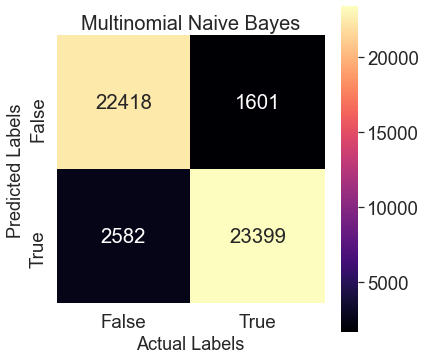

In [108]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test, mnb_predicted, y.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Multinomial Naive Bayes', fontsize=20);

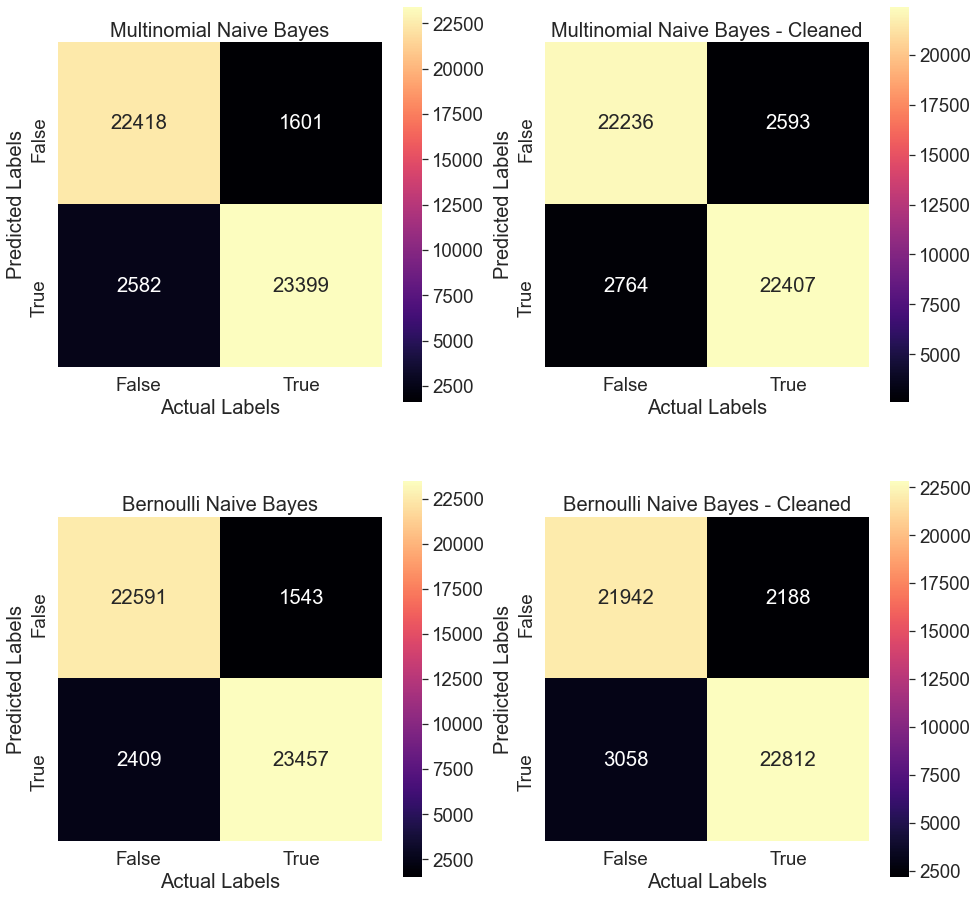

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))
preds = [mnb_predicted, mnb_predicted_clean, bnb_predicted, bnb_predicted_clean]
titles = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes - Cleaned', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes - Cleaned']
i = 0
for pred, ax in zip(preds, axs.flatten()):
    create_confusion_matrix(y_test, pred, y.unique(), ax=ax)
    ax.set_xlabel('Actual Labels', fontsize=20)
    ax.set_ylabel('Predicted Labels', fontsize=20)
    ax.set_title(titles[i], fontsize=20)
    i += 1
    
#plt.savefig('confusion_matrices.png')

In [53]:
preds = [mnb_predicted, mnb_predicted_clean, bnb_predicted, bnb_predicted_clean]
titles = ['Multinomial Naive Bayes', 'Multinomial Naive Bayes - Cleaned', 'Bernoulli Naive Bayes', 'Bernoulli Naive Bayes - Cleaned']
accs = []
precs = []
recs = []
for idx, pred in enumerate(preds):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    accs.append(accuracy)
    precs.append(precision)
    recs.append(recall)
    print(f'\nModel: {titles[idx]}')
    print("The accuracy on the test set is {0:0.3f}.".format(accuracy))
    print("The precision on the test set is {0:0.3f}.".format(precision))
    print("The recall on the test set is {0:0.3f}.".format(recall))

print(f'\nThe model with the highest accuracy: {titles[int(np.where(accs == np.max(accs))[0])]}')
print(f'The model with the highest precision: {titles[int(np.where(precs == np.max(precs))[0])]}')
print(f'The model with the highest recall: {titles[int(np.where(recs == np.max(recs))[0])]}')


Model: Multinomial Naive Bayes
The accuracy on the test set is 0.916.
The precision on the test set is 0.901.
The recall on the test set is 0.936.

Model: Multinomial Naive Bayes - Cleaned
The accuracy on the test set is 0.893.
The precision on the test set is 0.890.
The recall on the test set is 0.896.

Model: Bernoulli Naive Bayes
The accuracy on the test set is 0.921.
The precision on the test set is 0.907.
The recall on the test set is 0.938.

Model: Bernoulli Naive Bayes - Cleaned
The accuracy on the test set is 0.895.
The precision on the test set is 0.882.
The recall on the test set is 0.912.

The model with the highest accuracy: Bernoulli Naive Bayes
The model with the highest precision: Bernoulli Naive Bayes
The model with the highest recall: Bernoulli Naive Bayes


In [111]:
# conf_mat_clean = confusion_matrix(y_test, predicted_clean)
# tn, fp, fn, tp = conf_mat_clean.ravel()
# tn, fp, fn, tp #making sure the confusion matrix is outputting the correct information

In [112]:
# cm_display = ConfusionMatrixDisplay(conf_mat).plot()

## Testing the model(s) on new (made up) data

In [140]:
def get_predictions(text, pipeline):
    prediction = pipeline.predict([text])
    return prediction

In [54]:
# humorous - https://www.fatherly.com/play/best-coronavirus-jokes/
# serious - https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html
# text_humorous_1 = 'My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!'
# text_humorous_2 = 'If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.'
# text_serious_1 = 'To help prevent the spread of COVID-19, everyone should wear a mask in public.'
# text_serious_2 = 'Avoid close contact with people who are sick.'

In [141]:
def get_multiple_predictions(text_list, label_list, pipeline):
    for idx, text in enumerate(text_list):
        if get_predictions(text=text, pipeline=pipeline)[0] == True:
            pred = 'Humorous'
        else: pred = 'Serious'
        print(f'Text: {text}\nPrediction: {pred}\nLabel: {label_list[idx]}\n')

In [143]:
google_form_responses = pd.read_csv('data/google_form_responses.csv')

In [144]:
google_form_responses.rename(columns={'Short Text:': 'text', 'True or False - The text is humorous.': 'humor'}, inplace=True)
google_form_responses

,Timestamp,Your Name:,text,humor
0,12/3/2020 9:34:39,Heather,"When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'",True
1,12/3/2020 9:35:55,Heather,Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.,False
2,12/3/2020 9:43:14,George,How did the random variable get into the club? By showing a fake i.i.d.,True
3,12/3/2020 10:20:32,nico,Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion,False
4,12/3/2020 11:27:47,Mario,"Saddest 6 word story: ""Soup of the Day: No Soup.""",True
5,12/3/2020 11:56:25,Erin,"My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!",True
6,12/3/2020 11:56:42,Erin,"If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.",True
7,12/3/2020 11:56:56,Erin,"To help prevent the spread of COVID-19, everyone should wear a mask in public.",False
8,12/3/2020 11:57:13,Erin,Avoid close contact with people who are sick.,False
9,12/3/2020 12:34:58,Jamie,What did one support vector say to another support vector? I feel so marginalized.,True


In [145]:
X_new = google_form_responses.copy()
X_new

,Timestamp,Your Name:,text,humor
0,12/3/2020 9:34:39,Heather,"When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'",True
1,12/3/2020 9:35:55,Heather,Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.,False
2,12/3/2020 9:43:14,George,How did the random variable get into the club? By showing a fake i.i.d.,True
3,12/3/2020 10:20:32,nico,Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion,False
4,12/3/2020 11:27:47,Mario,"Saddest 6 word story: ""Soup of the Day: No Soup.""",True
5,12/3/2020 11:56:25,Erin,"My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!",True
6,12/3/2020 11:56:42,Erin,"If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.",True
7,12/3/2020 11:56:56,Erin,"To help prevent the spread of COVID-19, everyone should wear a mask in public.",False
8,12/3/2020 11:57:13,Erin,Avoid close contact with people who are sick.,False
9,12/3/2020 12:34:58,Jamie,What did one support vector say to another support vector? I feel so marginalized.,True


In [146]:
google_form_responses.loc[(google_form_responses.humor == True), 'humor'] = 'Humorous'

In [147]:
google_form_responses.loc[(google_form_responses.humor == False), 'humor'] = 'Serious'

In [148]:
text_list = list(google_form_responses.text)
label_list = list(google_form_responses.humor)
get_multiple_predictions(text_list=text_list, label_list=label_list, pipeline=bnb_pipeline)

Text: When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'
Prediction: Humorous
Label: Humorous

Text: Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.
Prediction: Humorous
Label: Serious

Text: How did the random variable get into the club? By showing a fake i.i.d.
Prediction: Humorous
Label: Humorous

Text: Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion
Prediction: Serious
Label: Serious

Text: Saddest 6 word story: "Soup of the Day: No Soup."
Prediction: Humorous
Label: Humorous

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous
Label: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous
Label: Hu

In [149]:
X_test_new = X_new['text']
y_test_new = X_new['humor']

In [150]:
bnb_predicted_new = bnb_pipeline.predict(X_test_new)

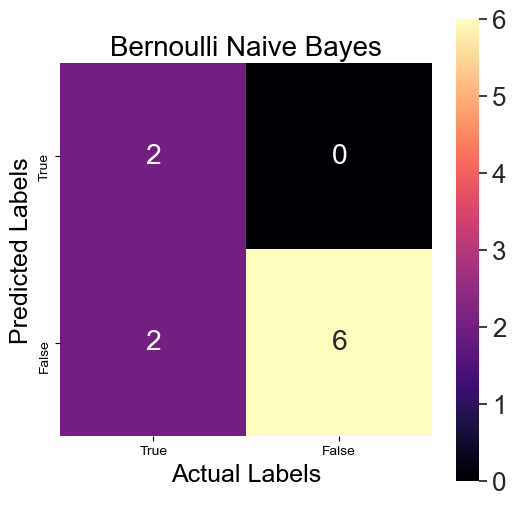

In [151]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test_new, bnb_predicted_new, y_test_new.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Bernoulli Naive Bayes', fontsize=20);

In [152]:
accuracy_new = accuracy_score(y_test_new, bnb_predicted_new)
precision_new = precision_score(y_test_new, bnb_predicted_new)
recall_new = recall_score(y_test_new, bnb_predicted_new)

print("The accuracy on the test set is {0:0.3f}.".format(accuracy_new))
print("The precision on the test set is {0:0.3f}.".format(precision_new))
print("The recall on the test set is {0:0.3f}.".format(recall_new))

The accuracy on the test set is 0.800.
The precision on the test set is 0.750.
The recall on the test set is 1.000.


## ROC Curve

> * ROC - When it is actually the negative result, how often does it predict correctly?

In [113]:
y_test_values = y_test.values
y_test_values = np.where(y_test_values, 1, 0)
y_test_values

array([1, 0, 1, ..., 1, 1, 0])

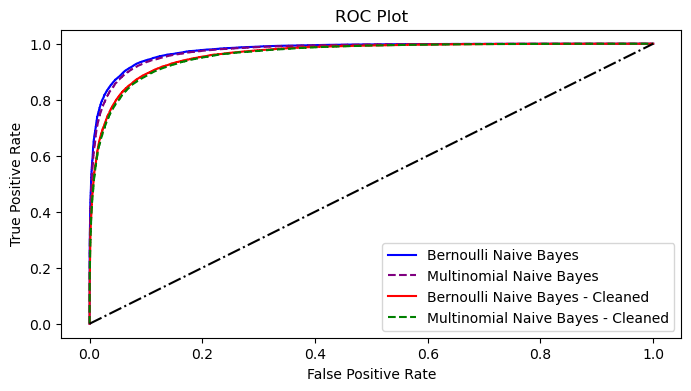

In [117]:
mnb_probs = mnb_pipeline.predict_proba(X_test)[:, 1]
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test_values, mnb_probs)

mnb_probs_clean = mnb_pipeline_clean.predict_proba(X_test_clean)[:, 1]
mnb_fpr_clean, mnb_tpr_clean, mnb_thresholds_clean = roc_curve(y_test_values, mnb_probs_clean)

bnb_probs = bnb_pipeline.predict_proba(X_test)[:, 1]
bnb_fpr, bnb_tpr, bnb_thresholds = roc_curve(y_test_values, bnb_probs)

bnb_probs_clean = bnb_pipeline_clean.predict_proba(X_test_clean)[:, 1]
bnb_fpr_clean, bnb_tpr_clean, bnb_thresholds_clean = roc_curve(y_test_values, bnb_probs_clean)

x = np.linspace(0, 1)

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(bnb_fpr, bnb_tpr, color = 'blue', label='Bernoulli Naive Bayes')
ax.plot(mnb_fpr, mnb_tpr, color ='purple', linestyle='--', label='Multinomial Naive Bayes')
ax.plot(bnb_fpr_clean, bnb_tpr_clean, color = 'red', label='Bernoulli Naive Bayes - Cleaned')
ax.plot(mnb_fpr_clean, mnb_tpr_clean, color = 'green', linestyle='--', label='Multinomial Naive Bayes - Cleaned')
ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend(loc='lower right');

#plt.savefig('NB_ROC.png')

In [122]:
probs = [mnb_probs, bnb_probs]
titles = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes']
scores = []

for idx, prob in enumerate(probs):
    score = roc_auc_score(y_test, prob)
    scores.append(score)
    print(f'\nModel: {titles[idx]}')
    print("The ROC AUC score for the model is {0:0.3f}.".format(score))

print(f'\nThe model with the largest AUC: {titles[int(np.where(scores == np.max(scores))[0])]}')


Model: Multinomial Naive Bayes
The ROC AUC score for the model is 0.975.

Model: Bernoulli Naive Bayes
The ROC AUC score for the model is 0.977.

The model with the largest AUC: Bernoulli Naive Bayes


## What texts does the best model have trouble with?

In [69]:
def get_misclassified_corpus(X_test, y_test, predicted):
    
    misclass = np.where((y_test != predicted))[0]
    misclass_idx = list(misclass)
    misclass_corpus = []
    for idx in misclass_idx:
        misclass_corpus.append(X_test.iloc[idx])

    fp = np.where((y_test == False) & (predicted == True))[0]
    fp_idx = list(fp)
    fp_corpus = []
    for idx in fp_idx:
        fp_corpus.append(X_test.iloc[idx])
    
    fn = np.where((y_test == True) & (predicted == False))[0]
    fn_idx = list(fn)
    fn_corpus = []
    for idx in fn_idx:
        fn_corpus.append(X_test.iloc[idx])
            
    return misclass_corpus, fp_corpus, fn_corpus

In [70]:
misclass_corpus, fp_corpus, fn_corpus = get_misclassified_corpus(X_test, y_test, bnb_predicted)

In [71]:
def make_word_cloud(corpus, wordcloud):
    corpus_clean = ' '.join(clean_corpus(corpus))
    word_cloud = wordcloud
    word_cloud.generate(corpus_clean)
    return word_cloud

In [72]:
wc_misclass = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_misclass = make_word_cloud(misclass_corpus, wc_misclass)

wc_fp = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_fp = make_word_cloud(fp_corpus, wc_fp)

wc_fn = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
word_cloud_fn = make_word_cloud(fn_corpus, wc_fn)

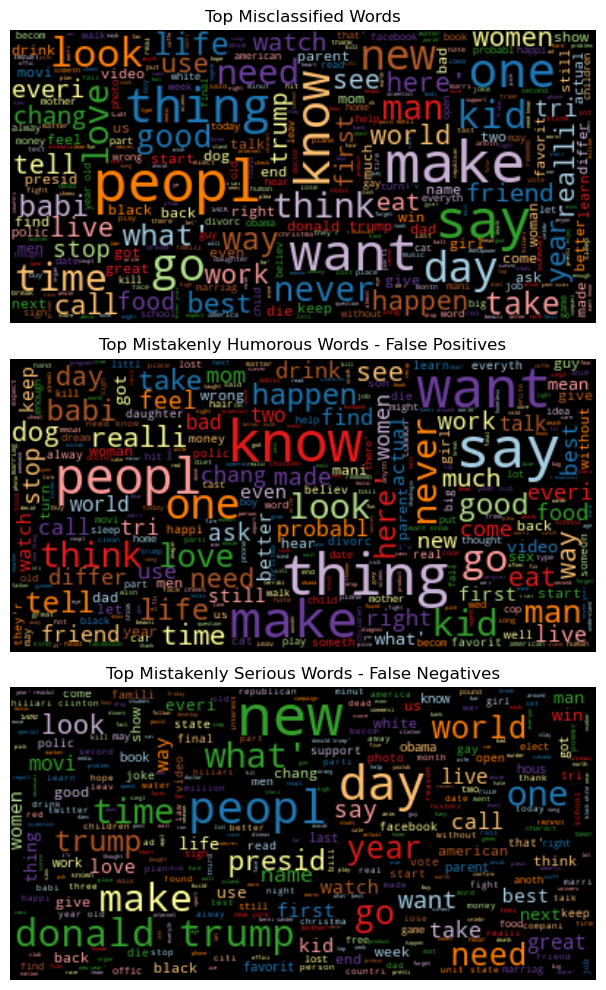

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
wordclouds = [word_cloud_misclass, word_cloud_fp, word_cloud_fn]
titles = ['Top Misclassified Words', 'Top Mistakenly Humorous Words - False Positives', 'Top Mistakenly Serious Words - False Negatives']

i = 0
for wordcloud, ax in zip(wordclouds, axs.flatten()):
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_axis_off()
    ax.set_title(titles[i])
    i += 1
fig.tight_layout()

In [74]:
get_top_words(word_cloud_misclass, num_words=10)

'The top 10 words are: make, peopl, say, want, know, one, thing, go, new, day'

## Exploring elminating top misclassified words

In [75]:
def even_cleaner_corpus(X):
    corpus = [text.lower() for text in X]
    tokenizer = RegexpTokenizer("[\w']+")
    tokens = list(map(tokenizer.tokenize, corpus))
    
    punc = set(string.punctuation)
    tokens_no_punc = [[word for word in words if word not in punc]
        for words in tokens]
   
    s_words = set(stopwords.words('english'))
    add_word = ['make', 'one', 'thing', 'say', 'people', 'know', 'want', 'new', 'kid', 'go']
    for word in add_word:
        s_words.add(word)

    tokens_no_sw = [[word for word in words if word not in s_words]
        for words in tokens_no_punc]
    
    porter = PS()
    tokens_stemmed = [[porter.stem(word) for word in text] for text in tokens_no_sw]
    
    new_corpus = [' '.join(word) for word in tokens_stemmed]
    
    return new_corpus

In [76]:
X_train_even_cleaner = even_cleaner_corpus(X_train)
X_test_even_cleaner = even_cleaner_corpus(X_test)

In [77]:
bnb_pipeline_even_cleaner = Pipeline([('tfidf', TfidfVectorizer()),
                                      ('model', BernoulliNB())])

bnb_predicted_even_cleaner = fit_predict_model_accuracy(bnb_pipeline_even_cleaner, X_train_even_cleaner, y_train, X_test_even_cleaner, y_test)


The accuracy on the test set is 0.896.


In [78]:
cleaner_misclass_corpus, cleaner_fp_corpus, cleaner_fn_corpus = get_misclassified_corpus(X_test, y_test, bnb_predicted_even_cleaner)

In [79]:
def make_word_cloud_even_cleaner(corpus, wordcloud):
    corpus_clean = ' '.join(even_cleaner_corpus(corpus))
    word_cloud = wordcloud
    word_cloud.generate(corpus_clean)
    return word_cloud

In [80]:
cleaner_wc_misclass = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_misclass = make_word_cloud_even_cleaner(cleaner_misclass_corpus, cleaner_wc_misclass)

cleaner_wc_fp = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_fp = make_word_cloud_even_cleaner(cleaner_fp_corpus, cleaner_wc_fp)

cleaner_wc_fn = WordCloud(colormap="Paired", relative_scaling=1, max_words=None, max_font_size=40)
cleaner_word_cloud_fn = make_word_cloud_even_cleaner(cleaner_fn_corpus, cleaner_wc_fn)

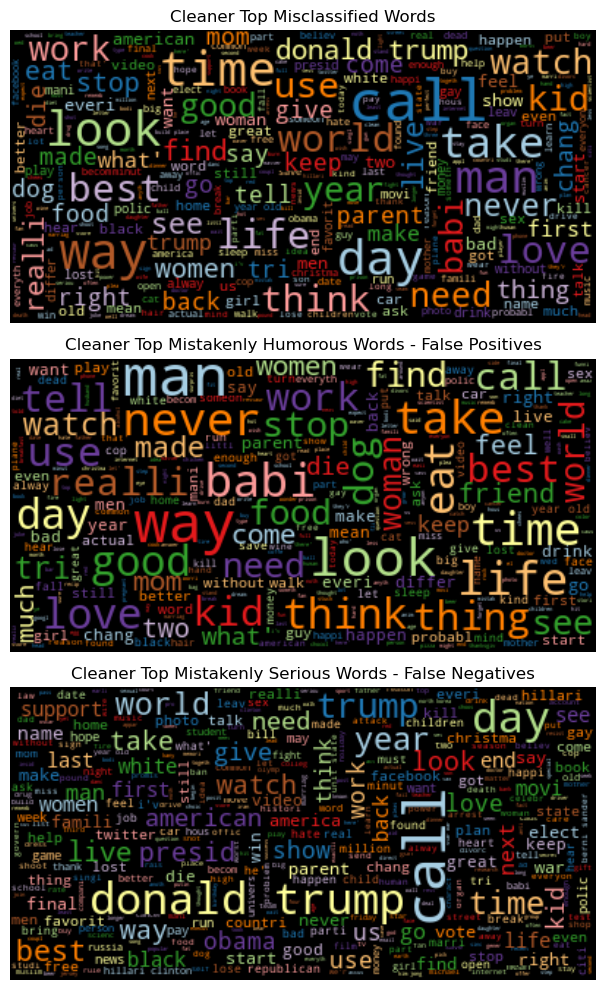

In [81]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
wordclouds = [cleaner_word_cloud_misclass, cleaner_word_cloud_fp, cleaner_word_cloud_fn]
titles = ['Cleaner Top Misclassified Words', 'Cleaner Top Mistakenly Humorous Words - False Positives', 'Cleaner Top Mistakenly Serious Words - False Negatives']

i = 0
for wordcloud, ax in zip(wordclouds, axs.flatten()):
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_axis_off()
    ax.set_title(titles[i])
    i += 1
fig.tight_layout()

In [82]:
get_top_words(cleaner_word_cloud_misclass, num_words=10)

'The top 10 words are: call, way, look, day, time, man, take, life, best, world'

In [73]:
# false_positives = np.where((y_test == False) & (bnb_predicted == True))[0]
# false_positives, len(false_positives)

In [74]:
# false_negatives = np.where((y_test == True) & (bnb_predicted == False))[0]
# false_negatives, len(false_negatives)

In [75]:
# fp_idx_samps = list(np.random.choice(false_positives, 5, replace=False))
# fp_idx_samps

In [76]:
# fn_idx_samps = list(np.random.choice(false_negatives, 5, replace=False))
# fn_idx_samps

In [77]:
# print('False Positives:')
# for idx in fp_idx_samps:
#     print(f'Quote: {X_test.iloc[idx]}\n Label: {y_test.iloc[idx]} \n Prediction: {bnb_predicted[idx]}\n')

In [78]:
# print('False Negatives:')
# for idx in fn_idx_samps:
#     print(f'Quote: {X_test.iloc[idx]}\n Label: {y_test.iloc[idx]}\n Prediction: {bnb_predicted[idx]}\n')

In [115]:
# str(text_humor).lower().count('call')

In [116]:
# str(text_serious).lower().count('photo')

## To Do

* Plot KMeans visually if time 
* Combine all models on ROC plot
* Get more predictions from others
* README and slides
* Functionize code

Build model(s) to classify text as humorous or serious
* Identify different clusters/topics within humorous text
* Identify different clusters/topics of serious text

* NLP - TFIDF gives tokens but not order, etc
* Naive Bayes Text Classification - supervised
* Random Forest - supervised
* Basic NN, MLP - supervised
* K-means topic clustering - unsupervised
* PCA - from Chelsea: remember!! PCA components point in the direction of variance, and are sorted in descending order where the first component describes most variance. Don't forget that pca.variance_ (or explained_variance_? idk) tells you how much that component is describing and we can plot the "scree" to find how many components are worth keeping! so keeping all 10 components in your word cloud kept a lot of unsignificant words!
* Topic Modeling with NMF? - Unsupervised
* XGBoost? - might take too long

## Random Forest

In [134]:
# rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=1000)),
#                         ('model', RandomForestClassifier(n_estimators=1000, max_depth=10, verbose=2))])
# rf_pipeline.fit(X_train, y_train)
# rf_predicted = rf_pipeline.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

building tree 323 of 1000
building tree 324 of 1000
building tree 325 of 1000
building tree 326 of 1000
building tree 327 of 1000
building tree 328 of 1000
building tree 329 of 1000
building tree 330 of 1000
building tree 331 of 1000
building tree 332 of 1000
building tree 333 of 1000
building tree 334 of 1000
building tree 335 of 1000
building tree 336 of 1000
building tree 337 of 1000
building tree 338 of 1000
building tree 339 of 1000
building tree 340 of 1000
building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tre

building tree 642 of 1000
building tree 643 of 1000
building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tre

building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tre

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


In [135]:
# print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, rf_predicted)))
# print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, rf_predicted)))
# print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, rf_predicted)))


The accuracy on the test set is 0.851.

The precision on the test set is 0.888.

The recall on the test set is 0.804.


In [123]:
# rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=5000, max_leaf_nodes=16, verbose=2))])
# rf_pipeline.fit(X_train, y_train)
# rf_predicted = rf_pipeline.predict(X_test)

In [124]:
# print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, rf_predicted)))
# print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, rf_predicted)))
# print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, rf_predicted)))

In [125]:
# num_trees = [100, 1000, 2000, 5000, 10000]
# accuracies = []

# for n in num_trees:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=2000)),
#                         ('model', RandomForestClassifier(n_estimators=n, 
#                                                          max_leaf_nodes=16, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))
    



In [126]:
# fig, ax = plt.subplots()
# ax.plot(num_trees, accuracies)
# ax.set_title('RF Accuracy by Number of Trees')
# ax.set_xlabel('num trees')
# ax.set_ylabel('accuracy');

In [127]:
# num_features = [100, 1000, 2000, 5000, 10000]
# accuracies = []

# for n in num_features:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=n)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_leaf_nodes=16, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

In [128]:
# fig, ax = plt.subplots()
# ax.plot(num_features, accuracies)
# ax.set_title('RF Accuracy by Max Features')
# ax.set_xlabel('num features')
# ax.set_ylabel('accuracy');

In [129]:
# num_leaf_nodes = [8, 16, 32, 64]
# accuracies = []

# for n in num_leaf_nodes:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_leaf_nodes=n, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

In [130]:
# fig, ax = plt.subplots()
# ax.plot(num_leaf_nodes, accuracies)
# ax.set_title('RF Accuracy by Max Leaf Nodes')
# ax.set_xlabel('max leaf nodes')
# ax.set_ylabel('accuracy');

In [131]:
# max_depths = [8, 16, 32, 64]
# accuracies = []

# for n in max_depths:
#     rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=None)),
#                         ('model', RandomForestClassifier(n_estimators=1000, 
#                                                          max_depth=n, 
#                                                          verbose=2))])

#     rf_pipeline.fit(X_train, y_train)
#     rf_predicted = rf_pipeline.predict(X_test)
#     accuracies.append(accuracy_score(y_test, rf_predicted))

In [132]:
# fig, ax = plt.subplots()
# ax.plot(max_depths, accuracies)
# ax.set_title('RF Accuracy by Max Depth')
# ax.set_xlabel('max depth')
# ax.set_ylabel('accuracy');

In [133]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]


In [90]:
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth}

# pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [91]:
# tfid = TfidfVectorizer()
# X_train_tfid = tfid.fit_transform(X_train)

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 3, 
#                                cv = 3, 
#                                verbose = 2, 
#                                n_jobs = -1)
# rf_random.fit(X_train_tfid, y_train)
# rf_random.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 58.4min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 58.6min finished


{'n_estimators': 1600, 'max_features': 'auto', 'max_depth': 90}

In [136]:
rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)),
                        ('model', RandomForestClassifier(n_estimators=1600, 
                                                         max_depth=90))])
rf_pipeline.fit(X_train, y_train)
rf_predicted = rf_pipeline.predict(X_test)

In [137]:
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, rf_predicted)))
print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, rf_predicted)))
print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, rf_predicted)))


The accuracy on the test set is 0.907.

The precision on the test set is 0.905.

The recall on the test set is 0.909.


In [153]:
get_multiple_predictions(text_list=text_list, label_list=label_list, pipeline=rf_pipeline)

Text: When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'
Prediction: Humorous
Label: Humorous

Text: Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.
Prediction: Humorous
Label: Serious

Text: How did the random variable get into the club? By showing a fake i.i.d.
Prediction: Humorous
Label: Humorous

Text: Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion
Prediction: Humorous
Label: Serious

Text: Saddest 6 word story: "Soup of the Day: No Soup."
Prediction: Serious
Label: Humorous

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous
Label: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous
Label: Hu

In [154]:
rf_predicted_new = rf_pipeline.predict(X_test_new)

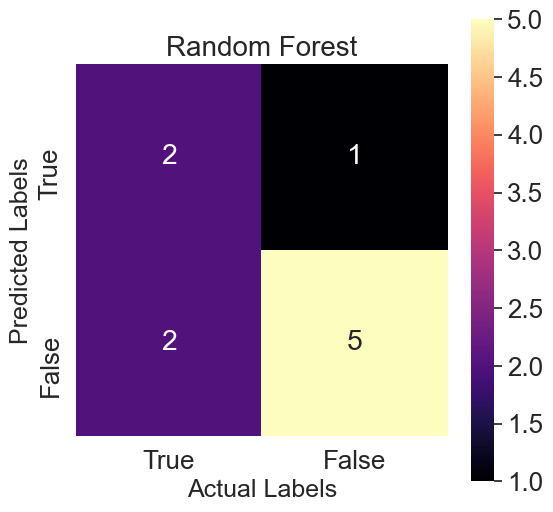

In [155]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test_new, rf_predicted_new, y_test_new.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Random Forest', fontsize=20);

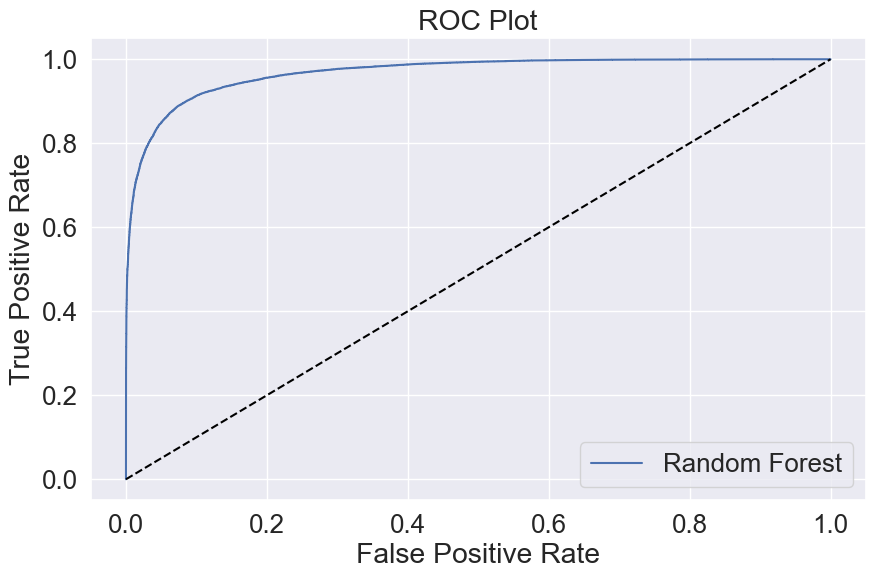

In [156]:
probs_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_values, probs_rf)

x = np.linspace(0, 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr_rf, tpr_rf, label='Random Forest')
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend();

In [158]:
score = roc_auc_score(y_test, probs_rf)
print("The ROC AUC score for the model is {0:0.3f}.".format(score))

The ROC AUC score for the model is 0.968.


## MLP

In [159]:
mlp_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=5000)), #10000 = 0.926, #5000 = 0.926, #1000 = 0.91
                        ('model', MLPClassifier(batch_size=32,
                                                hidden_layer_sizes=(32,),
                                                verbose=True,
                                                early_stopping=True))])

In [160]:
mlp_predicted = fit_predict_model_accuracy(mlp_pipeline, X_train, y_train, X_test, y_test)

Iteration 1, loss = 0.24208035
Validation score: 0.918400
Iteration 2, loss = 0.19378702
Validation score: 0.918067
Iteration 3, loss = 0.18345006
Validation score: 0.918733
Iteration 4, loss = 0.17481436
Validation score: 0.921333
Iteration 5, loss = 0.16474752
Validation score: 0.924133
Iteration 6, loss = 0.15422185
Validation score: 0.925133
Iteration 7, loss = 0.14287710
Validation score: 0.924800
Iteration 8, loss = 0.13173522
Validation score: 0.924133
Iteration 9, loss = 0.12088527
Validation score: 0.924733
Iteration 10, loss = 0.10997804
Validation score: 0.924067
Iteration 11, loss = 0.09894214
Validation score: 0.924067
Iteration 12, loss = 0.08821817
Validation score: 0.925000
Iteration 13, loss = 0.07766527
Validation score: 0.925067
Iteration 14, loss = 0.06798523
Validation score: 0.923933
Iteration 15, loss = 0.05915307
Validation score: 0.923267
Iteration 16, loss = 0.05184061
Validation score: 0.921867
Iteration 17, loss = 0.04559839
Validation score: 0.922267
Valida

In [161]:
print("\nThe accuracy on the test set is {0:0.3f}.".format(accuracy_score(y_test, mlp_predicted)))
print("\nThe precision on the test set is {0:0.3f}.".format(precision_score(y_test, mlp_predicted)))
print("\nThe recall on the test set is {0:0.3f}.".format(recall_score(y_test, mlp_predicted)))


The accuracy on the test set is 0.925.

The precision on the test set is 0.921.

The recall on the test set is 0.930.


In [162]:
get_multiple_predictions(text_list=text_list, label_list=label_list, pipeline=mlp_pipeline)

Text: When the prosecuting attorney asked Gucci Mane if he was guilty he said, 'bitch I might be.'
Prediction: Humorous
Label: Humorous

Text: Camus says that when you wish yourself into the future you commit suicide by wishing yourself closer to your death.
Prediction: Serious
Label: Serious

Text: How did the random variable get into the club? By showing a fake i.i.d.
Prediction: Humorous
Label: Humorous

Text: Laugh it up! Humor is universal across human cultures — and fuels psychological research on everything from social perception to emotion
Prediction: Humorous
Label: Serious

Text: Saddest 6 word story: "Soup of the Day: No Soup."
Prediction: Serious
Label: Humorous

Text: My mom always told me I wouldn’t accomplish anything by lying in bed all day. But look at me now, ma! I’m saving the world!
Prediction: Humorous
Label: Humorous

Text: If I keep stress-eating at this level, the buttons on my shirt will start socially distancing from each other.
Prediction: Humorous
Label: Hum

In [165]:
mlp_predicted_new = mlp_pipeline.predict(X_test_new)

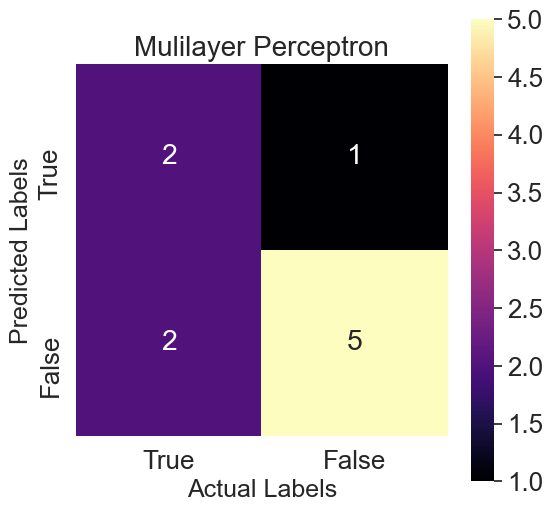

In [166]:
fig, ax = plt.subplots(figsize=(6,6))
create_confusion_matrix(y_test_new, mlp_predicted_new, y_test_new.unique(), ax=ax)
ax.set_xlabel('Actual Labels', fontsize=18)
ax.set_ylabel('Predicted Labels', fontsize=18)
ax.set_title('Mulilayer Perceptron', fontsize=20);

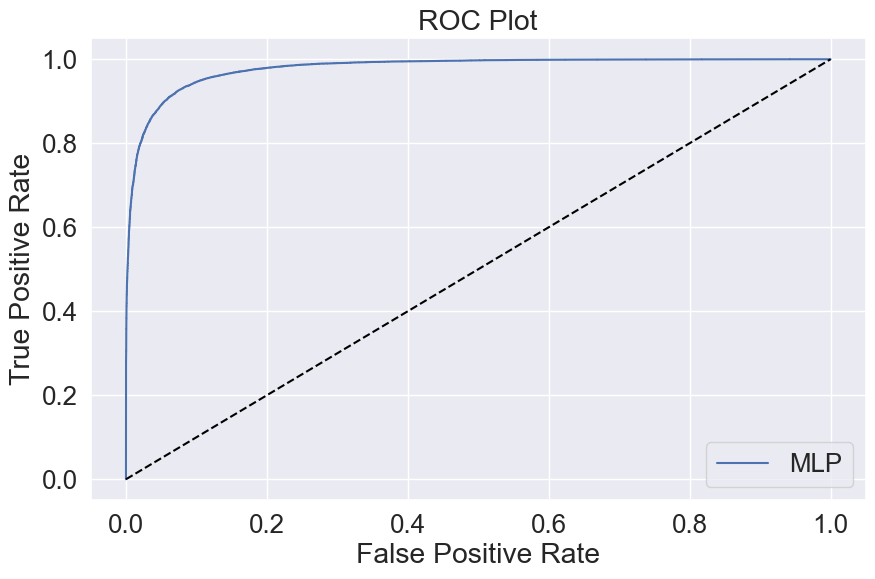

In [163]:
probs_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_values, probs_mlp)

x = np.linspace(0, 1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr_mlp, tpr_mlp, label='MLP')
ax.plot(x, x, color='black', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend();

In [164]:
score = roc_auc_score(y_test, probs_mlp)
print("The ROC AUC score for the model is {0:0.3f}.".format(score))

The ROC AUC score for the model is 0.979.


## Combined ROC

In [ ]:
# mnb_probs = mnb_pipeline.predict_proba(X_test)[:, 1]
# mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test_values, mnb_probs)

In [ ]:
# bnb_probs = bnb_pipeline.predict_proba(X_test)[:, 1]
# bnb_fpr, bnb_tpr, bnb_thresholds = roc_curve(y_test_values, bnb_probs)

In [ ]:
# probs_rf = rf_pipeline.predict_proba(X_test)[:, 1]
# fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_values, probs_rf)

In [ ]:
# probs_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]
# fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_values, probs_mlp)

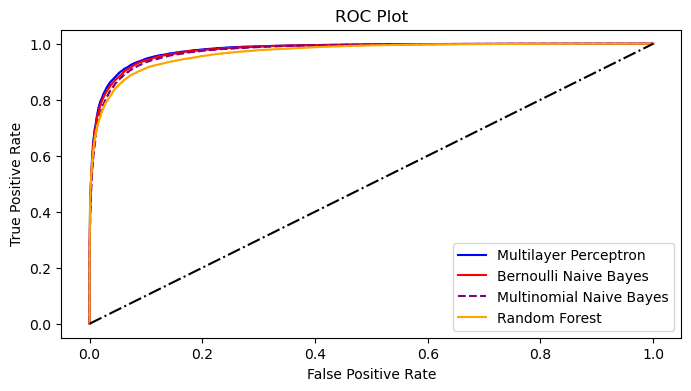

In [173]:
x = np.linspace(0, 1)

plt.style.use('default')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr_mlp, tpr_mlp, color = 'blue', label='Multilayer Perceptron')
ax.plot(bnb_fpr, bnb_tpr, color = 'red', label='Bernoulli Naive Bayes')
ax.plot(mnb_fpr, mnb_tpr, color ='purple', linestyle='--', label='Multinomial Naive Bayes')
ax.plot(fpr_rf, tpr_rf, color='orange', label='Random Forest')
ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot')
ax.legend(loc='lower right');

plt.savefig('Combined_ROC.png')

In [167]:
probs = [mnb_probs, bnb_probs, probs_rf, probs_mlp]
titles = ['Multinomial Naive Bayes', 'Bernoulli Naive Bayes', 'Random Forest', 'Multilayer Perceptron']
scores = []

for idx, prob in enumerate(probs):
    score = roc_auc_score(y_test, prob)
    scores.append(score)
    print(f'\nModel: {titles[idx]}')
    print("The ROC AUC score for the model is {0:0.3f}.".format(score))

print(f'\nThe model with the largest AUC: {titles[int(np.where(scores == np.max(scores))[0])]}')


Model: Multinomial Naive Bayes
The ROC AUC score for the model is 0.975.

Model: Bernoulli Naive Bayes
The ROC AUC score for the model is 0.977.

Model: Random Forest
The ROC AUC score for the model is 0.968.

Model: Multilayer Perceptron
The ROC AUC score for the model is 0.979.

The model with the largest AUC: Multilayer Perceptron


## KMeans Clustering

In [174]:
k = 2
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vec = vectorizer.fit_transform(X)
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=k, verbose=2)
kmeans.fit(X_vec) 

Initialization complete
Iteration 0, inertia 388149.1923786895
Iteration 1, inertia 191639.83093338553
Iteration 2, inertia 191579.34586228427
Iteration 3, inertia 191571.32482921568
Iteration 4, inertia 191571.321796483
Converged at iteration 4: center shift 1.3816486241020395e-34 within tolerance 9.62771570643571e-08
Initialization complete
Iteration 0, inertia 389157.41278499516
Iteration 1, inertia 192281.13332717467
Iteration 2, inertia 191630.92292303414
Iteration 3, inertia 191591.89389738793
Iteration 4, inertia 191591.89142576692
Converged at iteration 4: center shift 0.0 within tolerance 9.62771570643571e-08
Initialization complete
Iteration 0, inertia 386620.7441931095
Iteration 1, inertia 191247.9430580422
Iteration 2, inertia 191016.14089755775
Iteration 3, inertia 190970.47967394395
Iteration 4, inertia 190970.1624471822
Iteration 5, inertia 190970.10227877583
Iteration 6, inertia 190970.09539334147
Converged at iteration 6: center shift 9.36338254966766e-08 within tolera

KMeans(n_clusters=2, verbose=2)

In [175]:
print(kmeans.cluster_centers_)

[[0.00179168 0.00516285 0.0015433  ... 0.00088422 0.0021788  0.00150179]
 [0.00023603 0.00227284 0.00068274 ... 0.0002579  0.00042464 0.00082371]]


In [177]:
# Find the top 10 features for each cluster.
n_features = 10
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-(n_features+1):-1]
print("top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

top features (words) for each cluster:
0, like, trump, new, just, people, does, don, photos, make, know
1, did, say, hear, cross, road, got, man, chicken, know, guy


In [182]:
print("Random sample of texts in each cluster \n")
assigned_cluster = kmeans.transform(X_vec).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X_vec.shape[0])[assigned_cluster==i]
    sample_texts = np.random.choice(cluster, 10, replace=False)
    
    print(f'\n cluster {i}:')
    for idx in sample_texts:
        print(f'Quote: {X.iloc[idx]}\n Label: {y.iloc[idx]}')

Random sample of texts in each cluster 


 cluster 0:
Quote: Yo mama so fat... yo mama so fat , you can see what's behind her !
 Label: True
Quote: If love is blind why is lingerie so  popular?
 Label: True
Quote: What's a monster's favorite bean? a human bean.
 Label: True
Quote: Cheese shop exploded thankfully i was only hit by da brie
 Label: True
Quote: Stephanie gilmore's espy awards fashion is spot on (photos)
 Label: False
Quote: Why the 2-million pound ready-to-eat chicken recall is extra risky
 Label: False
Quote: Worrying is so stupid. it's like carrying an umbrella waiting for it to rain.
 Label: True
Quote: Watertown perspective: the boston marathon suspect manhunt on friday
 Label: False
Quote: The best place to get fit (hint: it's free)
 Label: False
Quote: Painting found in french attic is $137 million caravaggio, say experts
 Label: False

 cluster 1:
Quote: Did you hear about the new emo website? www.emo.com/wrists
 Label: True
Quote: What did the corn stalk say to the

In [179]:
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X_vec.shape[0])[assigned_cluster==i]
    categories = y.iloc[cluster]
    most_common = Counter(categories).most_common()
    print(f"Cluster {i}:")
    for j in range (len(most_common)):
        print(f"     {most_common[j][0]} ({most_common[j][1]} texts)")

Cluster 0:
     False (99587 texts)
     True (90012 texts)
Cluster 1:
     True (9988 texts)
     False (413 texts)


Initialization complete
Iteration 0, inertia 391663.7186153257
Iteration 1, inertia 192446.68253863548
Iteration 2, inertia 191831.0047963292
Iteration 3, inertia 191662.40935891971
Iteration 4, inertia 191566.34198131852
Iteration 5, inertia 191542.92592954455
Iteration 6, inertia 191538.76089908314
Iteration 7, inertia 191535.09627734005
Iteration 8, inertia 191527.86815429118
Iteration 9, inertia 191522.50793716704
Iteration 10, inertia 191521.92550169546
Iteration 11, inertia 191521.9064424729
Iteration 12, inertia 191521.89210512684
Iteration 13, inertia 191521.873112058
Iteration 14, inertia 191521.8617291789
Iteration 15, inertia 191521.8462012117
Iteration 16, inertia 191521.83218810437
Iteration 17, inertia 191521.82410405492
Converged at iteration 17: center shift 3.4219812169008336e-08 within tolerance 9.62771570643571e-08
Initialization complete
Iteration 0, inertia 386055.2612014247
Iteration 1, inertia 192167.7820566593
Iteration 2, inertia 191545.35495950683
Iteration 3,

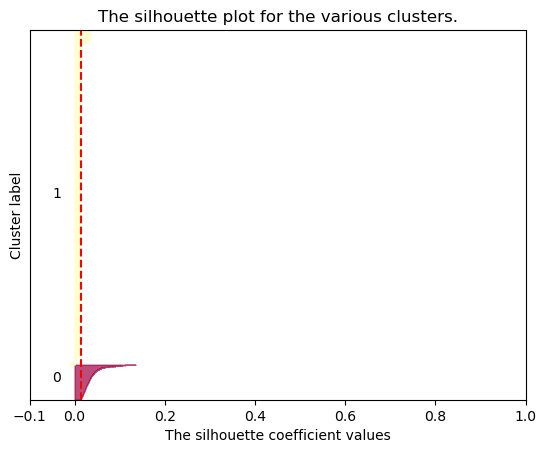

In [152]:
range_n_clusters = range(2,3)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    #fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X_vec.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, verbose=2, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_vec, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_vec, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed

#     colors = cmap(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors)

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1],
#                 marker='o', c="white", alpha=1, s=200)

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
#                   "with n_clusters = %d" % n_clusters),
#                  fontsize=14, fontweight='bold')

#     plt.show()

In [149]:
# plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')